In [1]:
import torch
from torch import nn
import torch.utils.data as Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from model import Net
from preprocessing import Create_Matrix, StandardScaler, Split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
timesteps = 90
batch_size = 512

In [3]:
data = pd.read_csv('bdi.csv', parse_dates=['date'], index_col=['date']).fillna(method='ffill').values

In [4]:
x, y = Create_Matrix(data, timesteps)
x_train, y_train, x_val, y_val, x_test, y_test = Split(x, y)

In [5]:
scaler = StandardScaler(y_train)
y_train = scaler.transform(y_train)
x_train = scaler.transform(x_train)
y_val = scaler.transform(y_val)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [6]:
x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
x_val = torch.FloatTensor(x_val).to(device)
y_val = torch.FloatTensor(y_val).to(device)
x_test = torch.FloatTensor(x_test).to(device)

In [7]:
dataset = Data.TensorDataset(x_train, y_train)
dataloader = Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [8]:
model = Net().to(device)
adam = torch.optim.Adam(model.parameters(), lr=0.01)
sgd = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [9]:
epochs = 200
history = dict()
history['loss'] = []
history['val_loss'] = []
best_model = np.inf
for epoch in range(epochs):
    for x_batch, y_batch in dataloader:
        model.train()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        adam.zero_grad()
        loss.backward()
        adam.step()
    with torch.no_grad():
        model.eval()
        y_pred = model(x_val)
        val_loss = criterion(y_pred, y_val)
        loss = loss.item()
        val_loss = val_loss.item()
    print(f'Epoch:{1+epoch:03d}-loss:{loss:.5f}-val_loss:{val_loss:.5f}')
    if val_loss <= best_model:
        best_model = val_loss
        torch.save(model, 'checkpoint.pt')
        print('weight_saved')
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
model = torch.load('checkpoint.pt')

weight_saved
Epoch:001-loss:0.11527-val_loss:0.01661
weight_saved
Epoch:002-loss:0.03240-val_loss:0.01309
weight_saved
Epoch:003-loss:0.00328-val_loss:0.00209
Epoch:004-loss:0.00334-val_loss:0.00285
weight_saved
Epoch:005-loss:0.00110-val_loss:0.00041
Epoch:006-loss:0.00139-val_loss:0.00045
weight_saved
Epoch:007-loss:0.00095-val_loss:0.00037
Epoch:008-loss:0.00102-val_loss:0.00042
Epoch:009-loss:0.00101-val_loss:0.00040
Epoch:010-loss:0.00147-val_loss:0.00038
weight_saved
Epoch:011-loss:0.00071-val_loss:0.00037
weight_saved
Epoch:012-loss:0.00090-val_loss:0.00033
Epoch:013-loss:0.00128-val_loss:0.00034
weight_saved
Epoch:014-loss:0.00089-val_loss:0.00032
Epoch:015-loss:0.00082-val_loss:0.00044
weight_saved
Epoch:016-loss:0.00071-val_loss:0.00028
Epoch:017-loss:0.00119-val_loss:0.00032
Epoch:018-loss:0.00093-val_loss:0.00037
weight_saved
Epoch:019-loss:0.00061-val_loss:0.00026
weight_saved
Epoch:020-loss:0.00088-val_loss:0.00025
Epoch:021-loss:0.00074-val_loss:0.00065
Epoch:022-loss:0.

Epoch:193-loss:0.00033-val_loss:0.00008
Epoch:194-loss:0.00030-val_loss:0.00022
Epoch:195-loss:0.00048-val_loss:0.00046
Epoch:196-loss:0.00060-val_loss:0.00007
Epoch:197-loss:0.00112-val_loss:0.00052
Epoch:198-loss:0.00032-val_loss:0.00008
Epoch:199-loss:0.00072-val_loss:0.00012
Epoch:200-loss:0.00030-val_loss:0.00024


In [10]:
with torch.no_grad():
    model.eval()
    pred = model(x_test)
    pred = pred.cpu().numpy()
    pred = scaler.inverse_transform(pred)

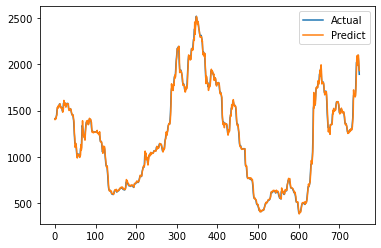

In [11]:
plt.plot(y_test, label='Actual')
plt.plot(pred, label='Predict')
plt.legend()
plt.show()

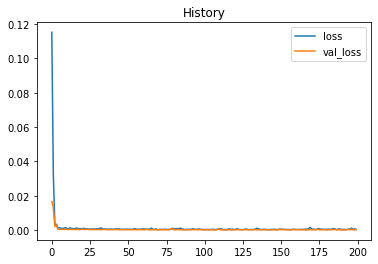

In [12]:
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.title('History')
plt.legend()
plt.show()

In [13]:
print(metrics.mean_absolute_error(pred, y_test))

17.603190755208335
